In [2]:
from collections import deque
import copy
from tqdm import tqdm
from typing import Callable
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision

# Googleドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('drive/MyDrive/python_image_recognition/4_classification/4_1_fnn')

import util
import transform

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
'''
DNN
一般的な層は、ReLU。出力層のあとはシグモイド・ソフトマックス
バッチ正規化：全結合層・畳み込みそうと活性化関数の間、学習を安定化させる、入力ミニバッチごとに標準化、各層の出力のスケールを標準化、ReLUを有効活用するための効果もじゃっぉ

指数平滑移動平均：ミニバッチが入力されるたびに更新され、移動平均の値は推論次の計算に使われる

'''

'\nDNN\n一般的な層は、ReLU。出力層のあとはシグモイド・ソフトマックス\nバッチ正規化：全結合層・畳み込みそうと活性化関数の間、学習を安定化させる、入力ミニバッチごとに標準化、各層の出力のスケールを標準化、ReLUを有効活用するための効果もじゃっぉ\n\n指数平滑移動平均：ミニバッチが入力されるたびに更新され、移動平均の値は推論次の計算に使われる\n\n'

In [4]:
class FNN(nn.Module):
    def __init__(
        self,
        dim_input: int,
        dim_hidden: int,
        num_hidden_layers: int,
        num_classes: int
    ):
        super().__init__()
        self.layers = nn.ModuleList() # 層の生成
        self.layers.append(self._generate_hidden_layer(dim_input, dim_hidden)) # 入力層->隠れ層
        for _ in range(num_hidden_layers-1): # 隠れ層->隠れ層
            self.layers.append(self._generate_hidden_layer(dim_hidden, dim_hidden))
        self.linear = nn.Linear(dim_hidden, num_classes)

    def _generate_hidden_layer(
        self,
        dim_input: int,
        dim_output: int
    ):
        layer = nn.Sequential(
            nn.Linear(dim_input, dim_output, bias=False), # 全結合層、バイアスパラメータを使う必要がない（バッチ正規化により平均が0になる
            nn.BatchNorm1d(dim_output),
            nn.ReLU(inplace=True) # メモリ使用量の削減
        )
        return layer

    def forward(
        self,
        x: torch.Tensor,
        return_embed: bool=False # Trueなら特徴量をそのまま返す
    ):
        h = x
        for layer in self.layers:
          h = layer(h)

        return h if return_embed else self.linear(h)

    def get_device(self):
        return self.linear.weight.device

    def copy(self):
      return copy.deepcopy(self)

In [5]:
class Config:
    '''
    ハイパーパラメータとオプションの設定
    '''
    def __init__(self):
        self.val_ratio = 0.2       # 検証に使う学習セット内のデータの割合
        self.dim_hidden = 512      # 隠れ層の特徴量次元
        self.num_hidden_layers = 2 # 隠れ層の数
        self.num_epochs = 30       # 学習エポック数
        self.lr = 1e-2             # 学習率
        self.moving_avg = 20       # 移動平均で計算する損失と正確度の値の数
        self.batch_size = 32       # バッチサイズ
        self.num_workers = 2       # データローダに使うCPUプロセスの数
        self.device = 'cpu'        # 学習に使うデバイス
        self.num_samples = 200     # t-SNEでプロットするサンプル数

def train_eval():
    config = Config()

    # 入力データ正規化のために学習セットのデータを使って
    # 各次元の平均と標準偏差を計算
    dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform.transform)
    channel_mean, channel_std = util.get_dataset_statistics(dataset)

    # 正規化を含めた画像整形関数の用意
    img_transform = lambda x: transform.transform(x, channel_mean, channel_std)

    # 学習、評価セットの用意
    train_dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=img_transform)
    test_dataset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=img_transform)

    # 学習・検証セットへ分割するためのインデックス集合の生成
    val_set, train_set = util.generate_subset(train_dataset, config.val_ratio)

    print(f'学習セットのサンプル数　: {len(train_set)}')
    print(f'検証セットのサンプル数　: {len(val_set)}')
    print(f'テストセットのサンプル数: {len(test_dataset)}')

    # インデックス集合から無作為にインデックスをサンプルするサンプラー
    train_sampler = SubsetRandomSampler(train_set)

    # DataLoaderを生成
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, num_workers=config.num_workers, sampler=train_sampler)
    val_loader = DataLoader(train_dataset, batch_size=config.batch_size, num_workers=config.num_workers, sampler=val_set)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, num_workers=config.num_workers)

    # 目的関数の生成
    loss_func = F.cross_entropy

    # 検証セットの結果による最良モデルの保存用変数
    val_loss_best = float('inf')
    model_best = None

    # FNNモデルの生成
    model = FNN(32 * 32 * 3, config.dim_hidden, config.num_hidden_layers, len(train_dataset.classes))

    # モデルを指定デバイスに転送(デフォルトはCPU)
    model.to(config.device)

    # 最適化器の生成
    optimizer = optim.SGD(model.parameters(), lr=config.lr)

    for epoch in range(config.num_epochs):
        model.train()

        with tqdm(train_loader) as pbar:
            pbar.set_description(f'[エポック {epoch + 1}]')

            # 移動平均計算用
            losses = deque()
            accs = deque()
            for x, y in pbar:
                # データをモデルと同じデバイスに転送
                x = x.to(model.get_device())
                y = y.to(model.get_device())

                # 既に計算された勾配をリセット
                optimizer.zero_grad()

                # 順伝播
                y_pred = model(x)

                # 学習データに対する損失と正確度を計算
                loss = loss_func(y_pred, y)
                accuracy = (y_pred.argmax(dim=1) == \
                            y).float().mean()

                # 誤差逆伝播
                loss.backward()

                # パラメータの更新
                optimizer.step()

                # 移動平均を計算して表示
                losses.append(loss.item())
                accs.append(accuracy.item())
                if len(losses) > config.moving_avg:
                    losses.popleft()
                    accs.popleft()
                pbar.set_postfix({
                    'loss': torch.Tensor(losses).mean().item(),
                    'accuracy': torch.Tensor(accs).mean().item()})

        # 検証セットを使って精度評価
        val_loss, val_accuracy = evaluate(val_loader, model, loss_func)
        print(f'検証　: loss = {val_loss:.3f}, '
              f'accuracy = {val_accuracy:.3f}')

        # より良い検証結果が得られた場合、モデルを記録
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            model_best = model.copy()

    # テスト
    test_loss, test_accuracy = evaluate(test_loader, model_best, loss_func)
    print(f'テスト: loss = {test_loss:.3f}, '
          f'accuracy = {test_accuracy:.3f}')

    # t-SNEを使って特徴量の分布をプロット
    plot_t_sne(test_loader, model_best, config.num_samples)

def evaluate(data_loader: Dataset, model: nn.Module,
             loss_func: Callable):
    model.eval()

    losses = []
    preds = []
    for x, y in data_loader:
        with torch.no_grad():
            x = x.to(model.get_device())
            y = y.to(model.get_device())

            y_pred = model(x)

            losses.append(loss_func(y_pred, y, reduction='none'))
            preds.append(y_pred.argmax(dim=1) == y)

    loss = torch.cat(losses).mean()
    accuracy = torch.cat(preds).float().mean()

    return loss, accuracy

def plot_t_sne(data_loader: Dataset, model: nn.Module,
               num_samples: int):
    model.eval()

    # t-SNEのためにデータを整形
    x = []
    y = []
    for imgs, labels in data_loader:
        with torch.no_grad():
            imgs = imgs.to(model.get_device())

            # 特徴量の抽出
            embeddings = model(imgs, return_embed=True)

            x.append(embeddings.to('cpu'))
            y.append(labels.clone())

    x = torch.cat(x)
    y = torch.cat(y)

    # NumPy配列に変換
    x = x.numpy()
    y = y.numpy()

    # 指定サンプル数だけ抽出
    x = x[:num_samples]
    y = y[:num_samples]

    # t-SNEを適用
    t_sne = TSNE(n_components=2, random_state=0)
    x_reduced = t_sne.fit_transform(x)

    # 各ラベルの色とマーカーを設定
    cmap = plt.get_cmap("tab10")
    markers = ['4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D']

    # データをプロット
    plt.figure(figsize=(20, 15))
    for i, cls in enumerate(data_loader.dataset.classes):
        plt.scatter(x_reduced[y == i, 0], x_reduced[y == i, 1],
                    c=[cmap(i / len(data_loader.dataset.classes))],
                    marker=markers[i], s=500, alpha=0.6, label=cls)
    plt.axis('off')
    plt.legend(bbox_to_anchor=(1, 1), fontsize=24, framealpha=0)
    plt.show()

100%|██████████| 170498071/170498071 [00:02<00:00, 68218954.19it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified
学習セットのサンプル数　: 40000
検証セットのサンプル数　: 10000
テストセットのサンプル数: 10000


[エポック 1]: 100%|██████████| 1250/1250 [00:32<00:00, 38.82it/s, loss=1.52, accuracy=0.442]


検証　: loss = 1.486, accuracy = 0.478


[エポック 2]: 100%|██████████| 1250/1250 [00:35<00:00, 35.20it/s, loss=1.36, accuracy=0.512]


検証　: loss = 1.402, accuracy = 0.506


[エポック 3]: 100%|██████████| 1250/1250 [00:42<00:00, 29.20it/s, loss=1.3, accuracy=0.536]


検証　: loss = 1.364, accuracy = 0.514


[エポック 4]: 100%|██████████| 1250/1250 [00:41<00:00, 30.05it/s, loss=1.29, accuracy=0.566]


検証　: loss = 1.347, accuracy = 0.520


[エポック 5]: 100%|██████████| 1250/1250 [00:29<00:00, 43.05it/s, loss=1.11, accuracy=0.609]


検証　: loss = 1.334, accuracy = 0.534


[エポック 6]: 100%|██████████| 1250/1250 [00:28<00:00, 43.99it/s, loss=1.08, accuracy=0.62]


検証　: loss = 1.315, accuracy = 0.535


[エポック 7]: 100%|██████████| 1250/1250 [00:28<00:00, 44.51it/s, loss=1.07, accuracy=0.63]


検証　: loss = 1.295, accuracy = 0.553


[エポック 8]: 100%|██████████| 1250/1250 [00:28<00:00, 43.38it/s, loss=0.986, accuracy=0.636]


検証　: loss = 1.332, accuracy = 0.541


[エポック 9]: 100%|██████████| 1250/1250 [00:27<00:00, 44.83it/s, loss=0.91, accuracy=0.678]


検証　: loss = 1.319, accuracy = 0.545


[エポック 10]: 100%|██████████| 1250/1250 [00:27<00:00, 45.33it/s, loss=0.92, accuracy=0.672]


検証　: loss = 1.343, accuracy = 0.543


[エポック 11]: 100%|██████████| 1250/1250 [00:27<00:00, 45.22it/s, loss=0.923, accuracy=0.663]


検証　: loss = 1.367, accuracy = 0.537


[エポック 12]: 100%|██████████| 1250/1250 [00:28<00:00, 44.44it/s, loss=0.837, accuracy=0.695]


検証　: loss = 1.369, accuracy = 0.553


[エポック 13]: 100%|██████████| 1250/1250 [00:28<00:00, 43.67it/s, loss=0.729, accuracy=0.739]


検証　: loss = 1.390, accuracy = 0.547


[エポック 14]: 100%|██████████| 1250/1250 [00:27<00:00, 46.05it/s, loss=0.745, accuracy=0.739]


検証　: loss = 1.463, accuracy = 0.525


[エポック 15]: 100%|██████████| 1250/1250 [00:27<00:00, 46.07it/s, loss=0.724, accuracy=0.741]


検証　: loss = 1.433, accuracy = 0.544


[エポック 16]: 100%|██████████| 1250/1250 [00:27<00:00, 45.23it/s, loss=0.601, accuracy=0.795]


検証　: loss = 1.497, accuracy = 0.535


[エポック 17]: 100%|██████████| 1250/1250 [00:26<00:00, 46.43it/s, loss=0.612, accuracy=0.789]


検証　: loss = 1.463, accuracy = 0.549


[エポック 18]: 100%|██████████| 1250/1250 [00:31<00:00, 39.26it/s, loss=0.619, accuracy=0.789]


検証　: loss = 1.485, accuracy = 0.549


[エポック 19]: 100%|██████████| 1250/1250 [00:28<00:00, 44.33it/s, loss=0.633, accuracy=0.766]


検証　: loss = 1.500, accuracy = 0.543


[エポック 20]: 100%|██████████| 1250/1250 [00:29<00:00, 42.87it/s, loss=0.504, accuracy=0.836]


検証　: loss = 1.512, accuracy = 0.545


[エポック 21]: 100%|██████████| 1250/1250 [00:29<00:00, 42.29it/s, loss=0.454, accuracy=0.842]


検証　: loss = 1.597, accuracy = 0.538


[エポック 22]: 100%|██████████| 1250/1250 [00:29<00:00, 42.09it/s, loss=0.495, accuracy=0.828]


検証　: loss = 1.564, accuracy = 0.549


[エポック 23]: 100%|██████████| 1250/1250 [00:29<00:00, 42.19it/s, loss=0.453, accuracy=0.842]


検証　: loss = 1.577, accuracy = 0.542


[エポック 24]: 100%|██████████| 1250/1250 [00:29<00:00, 43.10it/s, loss=0.468, accuracy=0.847]


検証　: loss = 1.645, accuracy = 0.539


[エポック 25]: 100%|██████████| 1250/1250 [00:29<00:00, 42.95it/s, loss=0.391, accuracy=0.878]


検証　: loss = 1.637, accuracy = 0.544


[エポック 26]: 100%|██████████| 1250/1250 [00:27<00:00, 44.75it/s, loss=0.415, accuracy=0.853]


検証　: loss = 1.698, accuracy = 0.538


[エポック 27]: 100%|██████████| 1250/1250 [00:28<00:00, 44.37it/s, loss=0.327, accuracy=0.887]


検証　: loss = 1.669, accuracy = 0.546


[エポック 28]: 100%|██████████| 1250/1250 [00:28<00:00, 44.15it/s, loss=0.34, accuracy=0.87]


検証　: loss = 1.771, accuracy = 0.537


[エポック 29]: 100%|██████████| 1250/1250 [00:28<00:00, 43.27it/s, loss=0.263, accuracy=0.913]


検証　: loss = 1.709, accuracy = 0.552


[エポック 30]: 100%|██████████| 1250/1250 [00:28<00:00, 43.55it/s, loss=0.333, accuracy=0.898]


検証　: loss = 1.754, accuracy = 0.543
テスト: loss = 1.308, accuracy = 0.538


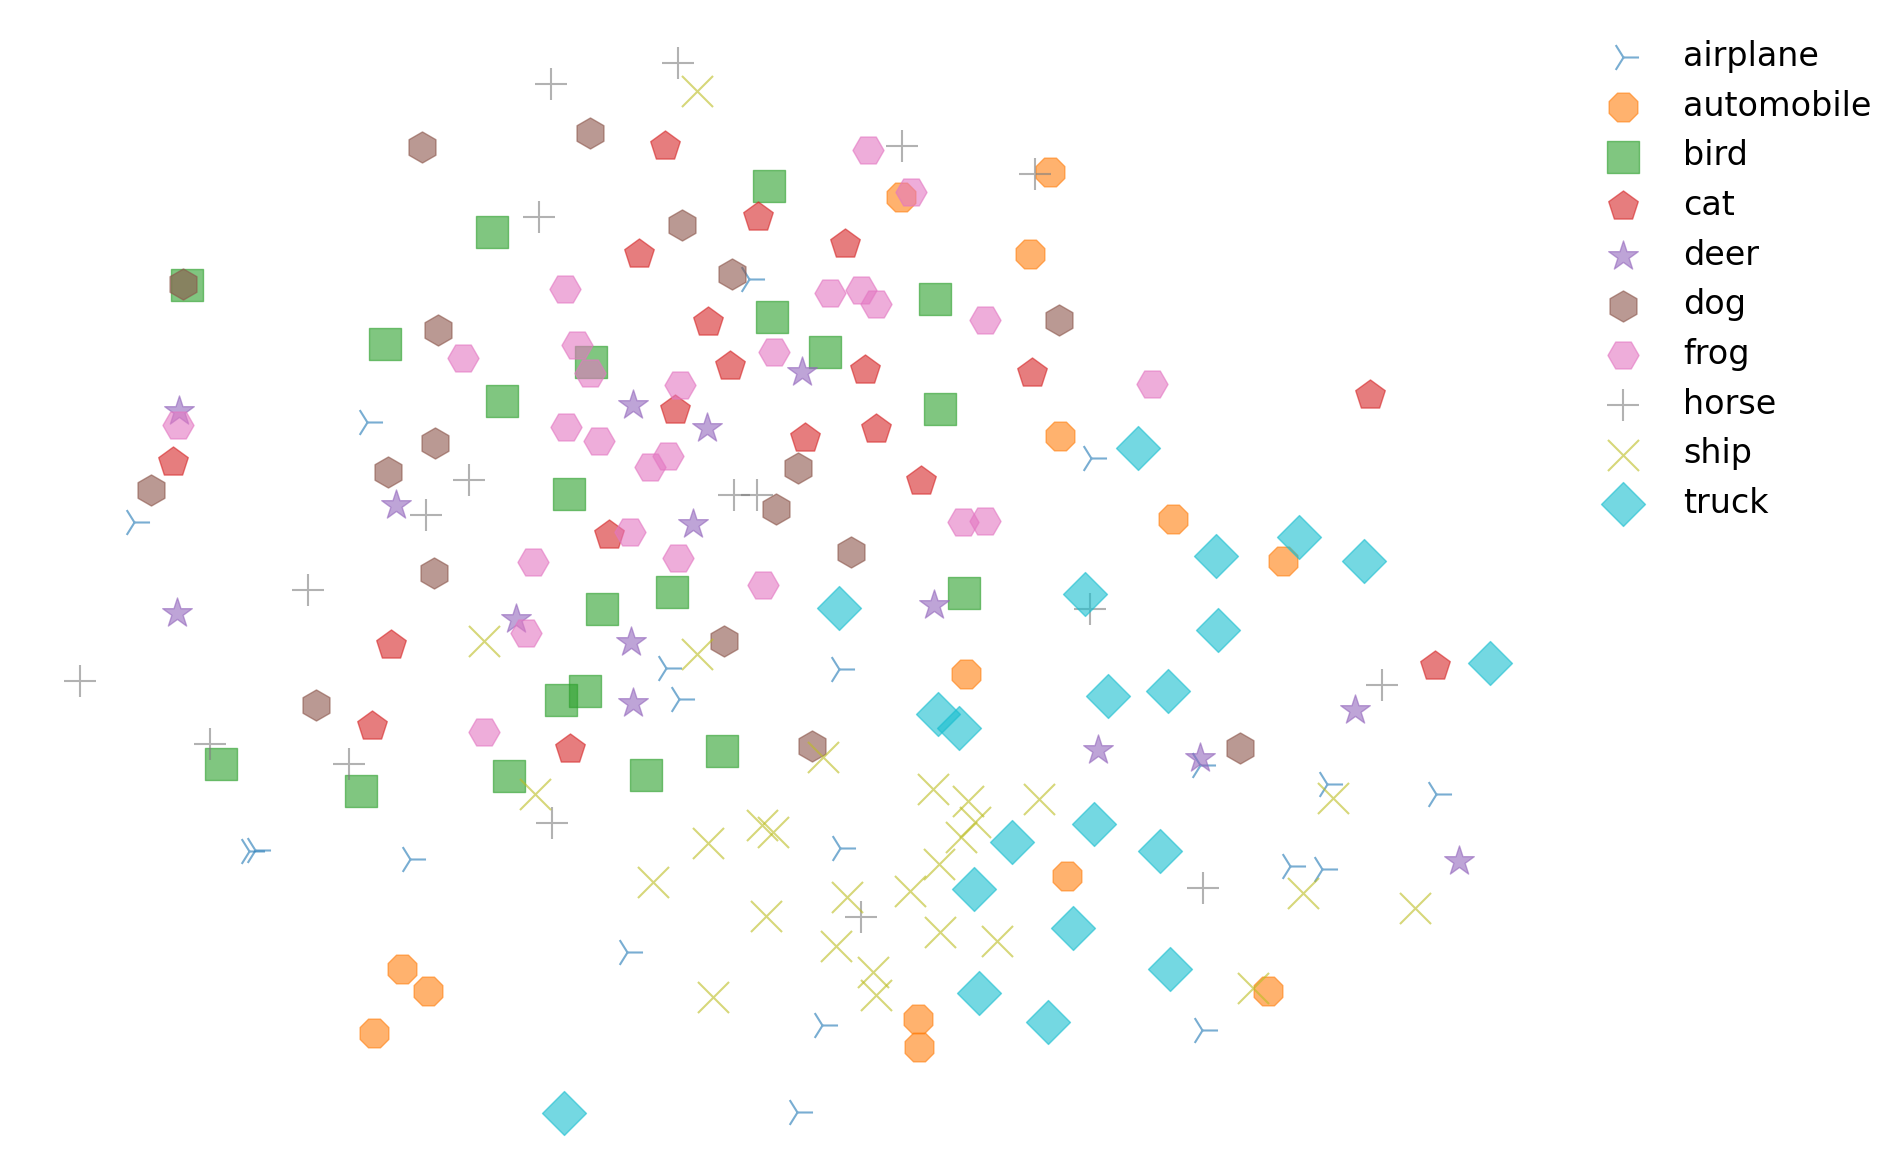

In [6]:
train_eval()